      naics1_occ1  naics1_occ2  naics1_occ3  naics1_occ4  naics1_occ5  \
FIPS                                                                    
1001    -0.207452    -0.200259     0.851999    -0.182367     0.719479   
1003     0.583683     0.720506     0.851999     0.309340     0.719479   
1005    -0.312937    -0.302567    -1.033262    -0.346269    -1.131038   
1007    -0.260194    -0.251413    -1.033262    -0.182367     0.719479   
1009    -0.154710    -0.097952     0.851999    -0.182367     0.719479   

      naics2-5_occ1-5  naics1_est  naics2-3_est  naics4-5_est  naics1_ap  \
FIPS                                                                       
1001        -0.262016   -0.231371     -0.241319     -0.184582  -0.235193   
1003         0.339027    0.572403     -0.014864      0.672864   0.441347   
1005        -0.278947   -0.369161     -0.241319     -0.291763  -0.262195   
1007        -0.199936   -0.311748     -0.241319     -0.286404  -0.243757   
1009        -0.262016   -0.15099

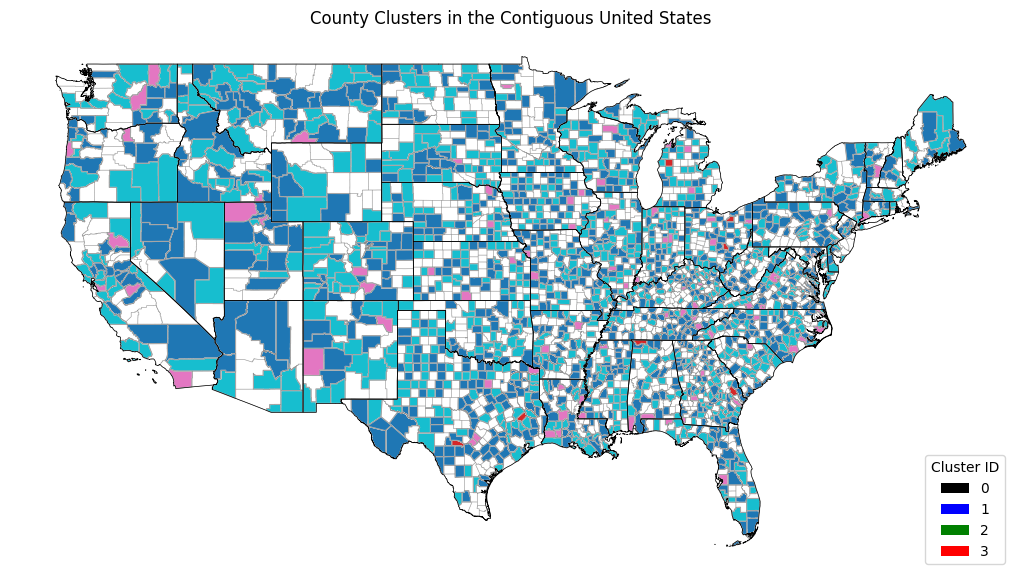

In [27]:
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the shape files
with open("../data/external/state.pkl", "rb") as file:
    state_shape = pickle.load(file)

with open("../data/external/county.pkl", "rb") as file:
    county_shape = pickle.load(file)

# Filter out non-continental states and territories
excluded_states = [
    "Alaska",
    "Hawaii",
    "Puerto Rico",
    "Commonwealth of the Northern Mariana Islands",
    "American Samoa",
    "United States Virgin Islands",
    "Guam",
]
filtered_statefp = state_shape.loc[
    ~state_shape["NAME"].isin(excluded_states), "STATEFP"
]
filtered_state_shape = state_shape[state_shape["STATEFP"].isin(filtered_statefp)]
filtered_county_shape = county_shape[county_shape["STATEFP"].isin(filtered_statefp)]

# Assign colors to Cluster_ID
code_to_color = {0: "black", 1: "blue", 2: "green", 3: "red"}

# Load the result DataFrame that contains the County to Cluster mapping
with open("../data/processed/master_df_scaled.pkl", "rb") as file:
    result_df = pickle.load(file)

# Add the identifier column manually
# Here, we assume you have a way to match result_df rows to the county shapefile, e.g., adding a GEOID column
# For this example, I'll create a dummy column for demonstration
result_df["GEOID"] = (
    filtered_county_shape["GEOID"].sample(n=len(result_df), replace=True).values
)
result_df["Color"] = result_df["clusters"].map(code_to_color)

# Print the columns to verify
print(result_df.head())

# Merge based on the common column 'GEOID'
merged_county_shape = filtered_county_shape.merge(
    result_df[["GEOID", "Color"]], left_on="GEOID", right_on="GEOID"
)

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the counties with colors based on the clusters
merged_county_shape.plot(
    column="Color", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True
)

# Plot the state and county borders
filtered_county_shape.plot(
    ax=ax, color="none", edgecolor="gray", linewidth=0.4, alpha=0.5
)
filtered_state_shape.plot(ax=ax, color="none", edgecolor="black", linewidth=0.5)

# Create a custom legend
sorted_code_to_color = sorted(code_to_color.items(), key=lambda x: x[0])
legend_elements = [
    Patch(facecolor=color, label=str(code)) for code, color in sorted_code_to_color
]

ax.legend(handles=legend_elements, title="Cluster ID", loc="lower right")

plt.title("County Clusters in the Contiguous United States")
plt.axis("off")
plt.show()